# Trabajando con filtrado basado en contenido (Content-Based Filtering) para nuestro sistema de recomendacion basado en productos de Amazon

### Paso 1: Importar las librerias necesarias


In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json

from collections import Counter



### Paso 2: Cargando los datos


Los datos se pueden descargar de la siguiente liga en donde se pueden ver todas las categorias que Amazon puede tener en los productos ofrecidos. Para este caso usamos los productos contenidos en la categoria "Handmade Products".

https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

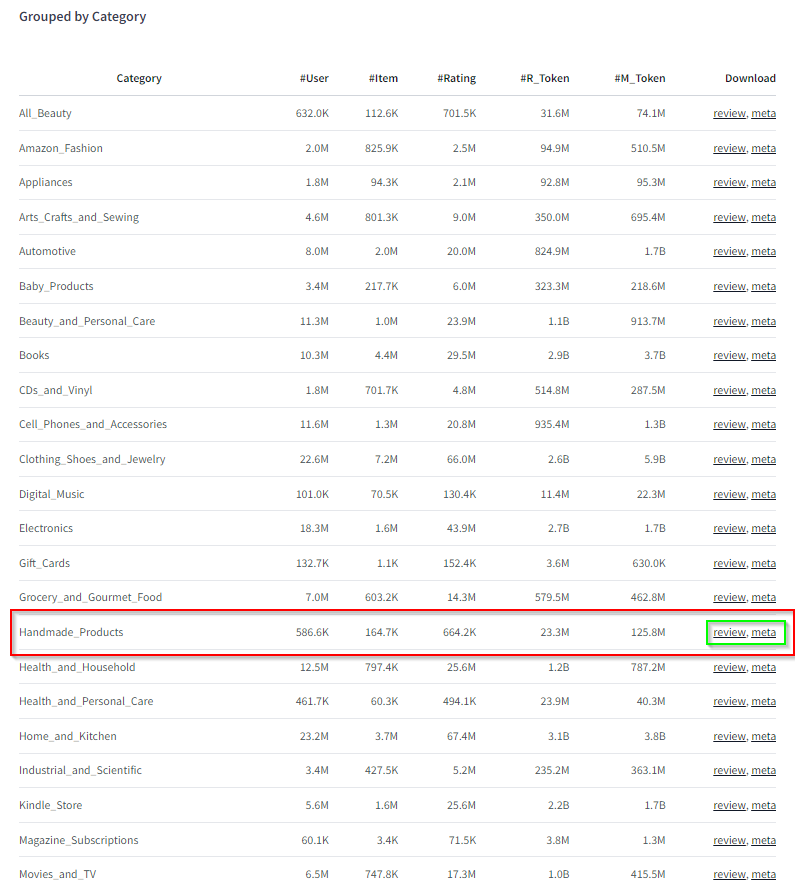

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def read_jsonl_gz(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

# Cargando los reviews/ratings
reviews = read_jsonl_gz('/content/drive/MyDrive/Maestria MNA/3er_Trimestre/01_Big Data/06_Week 6/Actividad/Handmade_Products.jsonl.gz')

# Cargando las especificaciones de los productos
products = read_jsonl_gz('/content/drive/MyDrive/Maestria MNA/3er_Trimestre/01_Big Data/06_Week 6/Actividad/meta_Handmade_Products.jsonl.gz')

In [4]:
products.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Handmade,Daisy Keychain Wristlet Gray Fabric Key fob La...,4.5,12,"[High Quality Fabrics, Antique Brass Metallic ...",[This charming Daisy Fabric Keychain wristlet ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,"[Handmade Products, Clothing, Shoes & Accessor...",{'Package Dimensions': '8 x 4 x 0.85 inches; 0...,B07NTK7T5P,None
1,Handmade,Anemone Jewelry Beauteous November Birthstone ...,4.1,10,"[Stunning gemstone and detailed design, Bands ...",[Anemone brings this November birthstone ring ...,69.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Anemone Jewelry,"[Handmade Products, Jewelry, Rings, Statement]","{'Department': 'womens', 'Date First Available...",B0751M85FV,None
2,Handmade,Silver Triangle Earrings with Chevron Pattern,5.0,1,[],[These large silver triangles are stamped with...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Zoë Noelle Designs,"[Handmade Products, Jewelry, Earrings, Drop & ...","{'Department': 'Women', 'Date First Available'...",B01HYNE114,None
3,Handmade,"Las Vegas Subway Sign Print - Caesar's, Freemo...",1.0,1,[],[Subway Signs make fabulous wall art. A bit of...,19.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,"[Handmade Products, Home & Kitchen, Artwork, P...","{'Date First Available': 'June 14, 2018'}",B07TKZF3Z1,None
4,Handmade,Round Cut Cubic Zirconia Stud Earrings Fashion...,4.2,2,[⭐【Size】The remarkable cubic zirconia studs ha...,[],14.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],VDKIDKT,"[Handmade Products, Jewelry, Earrings, Stud]",{'Package Dimensions': '2.36 x 2.05 x 1.65 inc...,B0BKBJT5MM,None


In [5]:
reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,[],B08GPJ1MSN,B08GPJ1MSN,AF7OANMNHQJC3PD4HRPX2FATECPA,1621607495111,1,True
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,[],B084TWHS7W,B084TWHS7W,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1587762946965,0,True
2,5.0,Great,As pictured. Used a frame from the dollar stor...,[],B07V3NRQC4,B07V3NRQC4,AEYORY2AVPMCPDV57CE337YU5LXA,1591448951297,0,True
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",[],B071ZMDK26,B071ZMDK26,AEINY4XOINMMJCK5GZ3M6MMHBN6A,1559438079784,2,True
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,[],B01MPVZ4YP,B01MPVZ4YP,AGCPAPUHXYA3EEIL2KGSQTGO5HRA,1546906331674,1,True


### Paso 3: Limpieza y Exploracion de los Datos


In [6]:
#Total productos unicos en el df
products['parent_asin'].nunique()

164817

In [7]:
#Total de productos sin precio
products['price'].isna().sum()

67169

In [9]:
#Definiendo el DF solamente para los datos del ID, titulo, precio y categorias
products = products[['parent_asin', 'title', 'price', 'categories']]

In [10]:
products.head()

,parent_asin,title,price,categories
0,B07NTK7T5P,Daisy Keychain Wristlet Gray Fabric Key fob La...,NaN,"[Handmade Products, Clothing, Shoes & Accessor..."
1,B0751M85FV,Anemone Jewelry Beauteous November Birthstone ...,69.00,"[Handmade Products, Jewelry, Rings, Statement]"
2,B01HYNE114,Silver Triangle Earrings with Chevron Pattern,NaN,"[Handmade Products, Jewelry, Earrings, Drop & ..."
3,B07TKZF3Z1,"Las Vegas Subway Sign Print - Caesar's, Freemo...",19.95,"[Handmade Products, Home & Kitchen, Artwork, P..."
4,B0BKBJT5MM,Round Cut Cubic Zirconia Stud Earrings Fashion...,14.99,"[Handmade Products, Jewelry, Earrings, Stud]"


In [14]:
ratings = reviews[['user_id', 'parent_asin', 'rating']]
ratings.head()

,user_id,parent_asin,rating
0,AF7OANMNHQJC3PD4HRPX2FATECPA,B08GPJ1MSN,5.0
1,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,B084TWHS7W,5.0
2,AEYORY2AVPMCPDV57CE337YU5LXA,B07V3NRQC4,5.0
3,AEINY4XOINMMJCK5GZ3M6MMHBN6A,B071ZMDK26,5.0
4,AGCPAPUHXYA3EEIL2KGSQTGO5HRA,B01MPVZ4YP,5.0


In [15]:
print(ratings.isnull().sum())

user_id        0
parent_asin    0
rating         0
dtype: int64


In [18]:
num_users = ratings['user_id'].nunique()
num_products = ratings['parent_asin'].nunique()
print("Number of unique users:", num_users)
print("Number of unique products:", num_products)

Number of unique users: 586613
Number of unique products: 164728


In [11]:
contador_categorias = Counter(c for categories in products['categories'] for c in categories if c != "Handmade Products") #Excluyendo Handmade Products ya que todos los productos recaen en esta categoria "madre"
contador_categorias = {category: count for category, count in contador_categorias.items() if count >= 100}
contador_categorias = Counter(contador_categorias)
print(f"Existen {len(contador_categorias)} tipos de categorias.")
contador_categorias

Existen 302 tipos de categorias.


Counter({'Clothing, Shoes & Accessories': 15604,
         'Luggage & Travel Gear': 5322,
         'Key & Identification Accessories': 3548,
         'Keychains & Keyrings': 2536,
         'Jewelry': 49955,
         'Rings': 6049,
         'Statement': 2881,
         'Earrings': 12796,
         'Drop & Dangle': 7710,
         'Home & Kitchen': 65228,
         'Artwork': 24827,
         'Prints': 18312,
         'Stud': 3322,
         'Stationery & Party Supplies': 13825,
         'Party Supplies': 6265,
         'Party Favors': 1655,
         'Home Décor': 25438,
         'Decorative Accessories': 12911,
         'Ornaments': 5465,
         'Stationery': 7382,
         'Appointment Books & Planners': 389,
         'Cleaning Supplies': 159,
         'Men': 4651,
         'Clothing': 6130,
         'Tops & Tees': 4006,
         'T-Shirts': 3289,
         'Stickers': 4068,
         'Signs & Plaques': 5018,
         'Bracelets': 8667,
         'Stretch': 1687,
         'Hoodies & Sweatshirt

In [12]:
#Imprimiendo las categorias mas comunes que existen entre los productos realizados a mano
print("Top 10 de categorias de productos: \n", contador_categorias.most_common(10))

Top 10 de categorias de productos: 
 [('Home & Kitchen', 65228), ('Jewelry', 49955), ('Home Décor', 25438), ('Artwork', 24827), ('Prints', 18312), ('Necklaces', 16117), ('Clothing, Shoes & Accessories', 15604), ('Stationery & Party Supplies', 13825), ('Decorative Accessories', 12911), ('Earrings', 12796)]


<ipython-input-13-bce13b38f517>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories', y='count', data=categories_counts_TOP, palette='rocket')


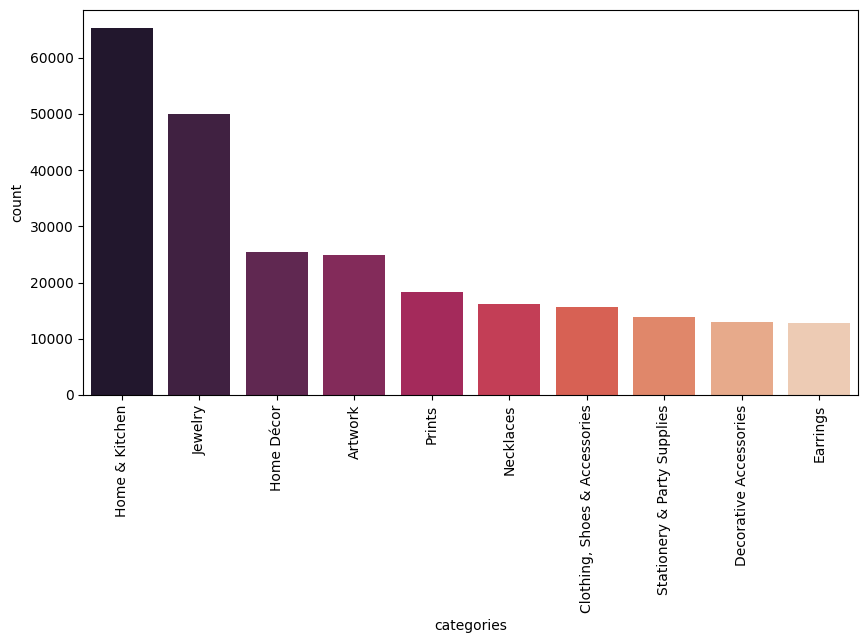

In [13]:
categories_counts = pd.DataFrame([contador_categorias]).T.reset_index()
categories_counts.columns = ['categories', 'count']
categories_counts = categories_counts.sort_values(by='count', ascending=False)
categories_counts_TOP = categories_counts.nlargest(10, 'count') #Visualizando solamente TOP 10

plt.figure(figsize=(10,5))
sns.barplot(x='categories', y='count', data=categories_counts_TOP, palette='rocket')
plt.xticks(rotation=90)
plt.show()

### Paso 4: Transformando los datos

Construyendo el sistema de recomendacion con filtrado basado en contenido teniendo las filas representando los productos y las columnas las categorias y el rango de precio

In [19]:
total_possible_interactions = num_users * num_products

In [20]:
actual_ratings = len(ratings)
print("Number of actual ratings:", actual_ratings)

Number of actual ratings: 664162


In [21]:
sparsity = 1 - (actual_ratings / total_possible_interactions)
print("Sparsity of the ratings matrix:", sparsity)

Sparsity of the ratings matrix: 0.9999931268643548


In [22]:
from scipy.sparse import csr_matrix

def create_X(df):

    N = df['user_id'].nunique()
    M = df['parent_asin'].nunique()

    mapeo_usuario = dict(zip(np.unique(df["user_id"]), list(range(N))))
    mapeo_producto = dict(zip(np.unique(df["parent_asin"]), list(range(M))))

    mapeo_inverso_usuario = dict(zip(list(range(N)), np.unique(df["user_id"])))
    mapeo_inverso_producto = dict(zip(list(range(M)), np.unique(df["parent_asin"])))

    user_index = [mapeo_usuario[i] for i in df['user_id']]
    producto_index = [mapeo_producto[i] for i in df['parent_asin']]

    X = csr_matrix((df["rating"], (producto_index, user_index)), shape=(M, N))

    return X, mapeo_usuario, mapeo_producto, mapeo_inverso_usuario, mapeo_inverso_producto

In [23]:
X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper = create_X(reviews)

In [24]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,8)}%")

Dispersion de la Matriz: 0.00067897%


In [25]:
from scipy.sparse import save_npz

save_npz('/content/drive/MyDrive/Maestria MNA/3er_Trimestre/01_Big Data/06_Week 6/Actividad/matriz_usuario_item.npz', X)

Paso 5: Obteniendo recomendaciones en base al producto ID

In [26]:
from sklearn.neighbors import NearestNeighbors

def encuentra_productos_parecidos(parent_asin, X, k, metric='cosine', show_distance=False):

    neighbour_ids = []

    product_ind = product_mapper[parent_asin]
    product_vec = X[product_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(product_vec, (np.ndarray)):
        product_vec = product_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(product_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(product_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [51]:
titulo_productos = dict(zip(products['parent_asin'], products['title']))

parent_asin = 'B01MPVZ4YP'

ids_parecidos = encuentra_productos_parecidos(parent_asin, X, k=5)
product_title = titulo_productos[parent_asin]

print(f"Por que compraste el producto {product_title}")
print(f"Te pueden interesar las siguientes productos:")
for i in ids_parecidos:
    if i in titulo_productos:
        print(titulo_productos[i])
    else:
        print(f"Product with ID '{i}' not found in titulo_productos")

Por que compraste el producto FLOWER DANCE Fragrance Oil 1oz Beaumondes Perfume Body Oil Similar to Flowerbomb Made in the USA Alcohol-Free Paraben-Free Cruelty-Free Phthalate-Free
Te pueden interesar las siguientes productos:
Red, White and Blue Chevron Over the Collar Dog Bandana That Slips onto Their Existing Collar Size Extra Small
Flower Dance Shower Gel Body Wash 8fl oz Beaumondes Paraben-Free
Black Orchid Body Scrub & Polish Sugar & Shea Beaumondes Scrub 12oz Made in USA Paraben Free 95% Natural
I Love Us, Personalized Love Picture Frames for Couples w/Names, Valentines Day Gifts - 4x6 - Custom Love Photo Frame - Portaretratos Amor
Black Orchid Fragrance Oil 1oz Perfume Body Oil Pure oil - Alcohol Free Made in the USA


Paso 6: Midiendo Recall

In [53]:
df_ground = ratings[['user_id','parent_asin']]

#producto analizado
target_product = "B01MPVZ4YP"

# usuarios que interactuaron con el producto
users = df_ground[df_ground['parent_asin'] == target_product]['user_id'].unique()

# productos comprados por usuarios excluyendo nuestros producto objetivo
related_products = df_ground[df_ground['user_id'].isin(users) & (df_ground['parent_asin'] != target_product)]

# conteo de interacciones con dichos productos
product_counts = related_products['parent_asin'].value_counts()

# seleccionando top 5 productos como valores relevantes
ground_truth = product_counts.head(5).index.tolist()
print(f"Valores Relevantes para producto {target_product}: {ground_truth}")


Valores Relevantes para producto B01MPVZ4YP: ['B01M4NC1SY', 'B01M9C70WO', 'B01N49LAE3', 'B07JDTY6QC', 'B07J368VHQ']


In [54]:
def calculate_recall_generated(parent_asin, X, k, generated_ground_truth):
    recommended_products = encuentra_productos_parecidos(parent_asin, X, k)
    relevant_recommended = set(recommended_products).intersection(generated_ground_truth)
    recall = len(relevant_recommended) / len(generated_ground_truth)
    return recall

# Obteniendo metrica recall para nuestro producto objetico:
parent_asin = "B01MPVZ4YP"
generated_ground_truth = ['B01M4NC1SY', 'B01M9C70WO', 'B01N49LAE3', 'B07JDTY6QC', 'B07J368VHQ']
recall = calculate_recall_generated(parent_asin, X, 5, generated_ground_truth)
print(f"Recall for product {parent_asin} with generated ground truth: {recall:.2f}")


Recall for product B01MPVZ4YP with generated ground truth: 0.60
